In [1]:
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry, SamPredictor
import cv2
import matplotlib.pyplot as plt # Plotting
import numpy as np # Numeric data
import pandas as pd # Tabular data
from rasterio.features import shapes # Vectorising rasters to polygons
from shapely import Point, LineString # Geometry
from shapely.geometry import box, shape
import geopandas as gpd # Plotting polygons
from tqdm.auto import tqdm # Progress bars
tqdm.pandas()

In [2]:
# Load SegmentAnything
checkpoint = 'sam_vit_h_4b8939.pth'
sam = sam_model_registry['vit_h'](checkpoint=checkpoint)
device = 'cuda:0'
sam.to(device)

img = cv2.cvtColor(cv2.imread('test.png'), cv2.COLOR_BGR2RGB)

In [3]:
masks = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32, # The number of points to be sampled along one side of the image
    pred_iou_thresh=0.88, # A filtering threshold in [0,1], using the model's predicted mask quality.
    stability_score_thresh=0.95, # The amount to shift the cutoff when calculated the stability score.
    box_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks.
    crop_nms_thresh=0.7, # The box IoU cutoff used by non-maximal suppression to filter duplicate masks between different crops.
    crop_n_layers=0, #  If >0, mask prediction will be run again on crops of the image. Sets the number of layers to run, where each layer has 2**i_layer number of image crops.
    crop_n_points_downscale_factor=1, # The number of points-per-side sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
    min_mask_region_area=100, # If >0, postprocessing will be applied to remove disconnected regions and holes in masks with area smaller than min_mask_region_area
).generate(img)
len(masks)

194

In [4]:
def bbox_to_shape(bbox):
    x,y,w,h = bbox
    return box(x,y,x+w,y+h)

def mask_to_shape(mask):
    return gpd.GeoSeries(shape(s) for s,v in shapes(mask.astype(np.uint8), mask)).unary_union

mask_shapes = gpd.GeoSeries([mask_to_shape(m["segmentation"]) for m in tqdm(masks)])
df = gpd.GeoDataFrame(masks, geometry=mask_shapes)
df

  0%|          | 0/194 [00:00<?, ?it/s]

segmentation    area   
0    [[False, False, False, False, False, False, Fa...   55264  \
1    [[False, False, False, False, False, False, Fa...    5215   
2    [[False, False, False, False, False, False, Fa...    1163   
3    [[False, False, False, False, False, False, Fa...    1081   
4    [[False, False, False, False, False, False, Fa...    1062   
..                                                 ...     ...   
189  [[False, False, False, False, False, False, Fa...  474123   
190  [[False, False, False, False, False, False, Fa...   40237   
191  [[False, False, False, False, False, False, Fa...    1997   
192  [[False, False, False, False, False, False, Fa...  143882   
193  [[False, False, False, False, False, False, Fa...      58   

                     bbox  predicted_iou            point_coords   
0      [45, 157, 89, 672]       1.012357   [[81.15625, 169.125]]  \
1      [657, 421, 65, 83]       1.006585  [[660.84375, 476.625]]   
2       [272, 95, 50, 28]       0.999485  [[313.03125, 107.625]]   
3      [470, 329, 37, 41]       0.998013  [[475.34375, 353.625]]   
4      [518, 350, 44, 31]       0.996523  [[544.90625, 353.625]]   
..                    ...            ...                     ...   
189    [151, 8, 573, 932]       0.997716  [[220.28125, 814.875]]   
190  [209, 850, 510, 133]       0.996687  [[591.28125, 876.375]]   
191    [466, 329, 41, 77]       0.957908  [[498.53125, 353.625]]   
192      [7, 8, 204, 968]       0.944285   [[81.15625, 384.375]]   
193      [446, 104, 9, 6]       0.884306  [[452.15625, 107.625]]   

     stability_score          crop_box   
0           0.987980  [0, 0, 742, 984]  \
1           0.988195  [0, 0, 742, 984]   
2           0.987201  [0, 0, 742, 984]   
3           0.992634  [0, 0, 742, 984]   
4           0.991581  [0, 0, 742, 984]   
..               ...               ...   
189         0.956580  [0, 0, 742, 984]   
190         0.957932  [0, 0, 742, 984]   
191         0.974790  [0, 0, 742, 984]   
192         0.966534  [0, 0, 742, 984]   
193         0.950000  [0, 0, 742, 984]   

                                              geometry  
0    POLYGON ((49.000 157.000, 57.000 157.000, 57.0...  
1    POLYGON ((708.000 421.000, 721.000 421.000, 72...  
2    POLYGON ((289.000 95.000, 313.000 95.000, 313....  
3    POLYGON ((471.000 329.000, 476.000 329.000, 47...  
4    POLYGON ((520.000 350.000, 534.000 350.000, 53...  
..                                                 ...  
189  POLYGON ((190.000 8.000, 207.000 8.000, 207.00...  
190  POLYGON ((667.000 850.000, 672.000 850.000, 67...  
191  POLYGON ((471.000 329.000, 476.000 329.000, 47...  
192  POLYGON ((17.000 8.000, 43.000 8.000, 43.000 9...  
193  POLYGON ((447.000 104.000, 454.000 104.000, 45...  

[194 rows x 8 columns]

In [5]:
df.geom_type.value_counts()

Polygon         191
MultiPolygon      3
Name: count, dtype: int64

In [6]:
# Make MultiPolygons into Polygons
df = df.explode()
df["area"] = df.area

/tmp/ipykernel_2804500/1282173786.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df = df.explode()


In [7]:
df["n_intersects"] = df.geometry.apply(lambda g: sum(df.intersects(g)))
df.describe()

area  predicted_iou  stability_score  n_intersects
count     197.000000     197.000000       197.000000    197.000000
mean     4624.025381       0.969594         0.982338      3.923858
std     35442.966978       0.021927         0.009823     12.381656
min        58.000000       0.884306         0.950000      2.000000
25%       754.000000       0.960536         0.975876      2.000000
50%       887.000000       0.974057         0.985045      3.000000
75%      1147.000000       0.984709         0.990123      4.000000
max    474123.000000       1.012357         0.998503    176.000000

In [8]:
df[df.n_intersects > 2]

segmentation      area   
0   0  [[False, False, False, False, False, False, Fa...   55264.0  \
1   0  [[False, False, False, False, False, False, Fa...    5215.0   
2   0  [[False, False, False, False, False, False, Fa...    1163.0   
3   0  [[False, False, False, False, False, False, Fa...    1081.0   
10  0  [[False, False, False, False, False, False, Fa...     885.0   
...                                                  ...       ...   
188 0  [[False, False, False, False, False, False, Fa...    1432.0   
189 0  [[False, False, False, False, False, False, Fa...  474123.0   
190 0  [[False, False, False, False, False, False, Fa...   40237.0   
191 0  [[False, False, False, False, False, False, Fa...    1997.0   
192 0  [[False, False, False, False, False, False, Fa...  143882.0   

                       bbox  predicted_iou            point_coords   
0   0    [45, 157, 89, 672]       1.012357   [[81.15625, 169.125]]  \
1   0    [657, 421, 65, 83]       1.006585  [[660.84375, 476.625]]   
2   0     [272, 95, 50, 28]       0.999485  [[313.03125, 107.625]]   
3   0    [470, 329, 37, 41]       0.998013  [[475.34375, 353.625]]   
10  0    [566, 470, 45, 24]       0.992233  [[591.28125, 476.625]]   
...                     ...            ...                     ...   
188 0    [388, 335, 63, 57]       0.892132  [[428.96875, 384.375]]   
189 0    [151, 8, 573, 932]       0.997716  [[220.28125, 814.875]]   
190 0  [209, 850, 510, 133]       0.996687  [[591.28125, 876.375]]   
191 0    [466, 329, 41, 77]       0.957908  [[498.53125, 353.625]]   
192 0      [7, 8, 204, 968]       0.944285   [[81.15625, 384.375]]   

       stability_score          crop_box   
0   0         0.987980  [0, 0, 742, 984]  \
1   0         0.988195  [0, 0, 742, 984]   
2   0         0.987201  [0, 0, 742, 984]   
3   0         0.992634  [0, 0, 742, 984]   
10  0         0.990991  [0, 0, 742, 984]   
...                ...               ...   
188 0         0.963649  [0, 0, 742, 984]   
189 0         0.956580  [0, 0, 742, 984]   
190 0         0.957932  [0, 0, 742, 984]   
191 0         0.974790  [0, 0, 742, 984]   
192 0         0.966534  [0, 0, 742, 984]   

                                                geometry  n_intersects  
0   0  POLYGON ((49.000 157.000, 57.000 157.000, 57.0...             3  
1   0  POLYGON ((708.000 421.000, 721.000 421.000, 72...             5  
2   0  POLYGON ((289.000 95.000, 313.000 95.000, 313....             3  
3   0  POLYGON ((471.000 329.000, 476.000 329.000, 47...             4  
10  0  POLYGON ((591.000 470.000, 605.000 470.000, 60...             4  
...                                                  ...           ...  
188 0  POLYGON ((397.000 335.000, 410.000 335.000, 41...             6  
189 0  POLYGON ((190.000 8.000, 207.000 8.000, 207.00...           176  
190 0  POLYGON ((667.000 850.000, 672.000 850.000, 67...            12  
191 0  POLYGON ((471.000 329.000, 476.000 329.000, 47...             4  
192 0  POLYGON ((17.000 8.000, 43.000 8.000, 43.000 9...             5  

[110 rows x 9 columns]

<Axes: >

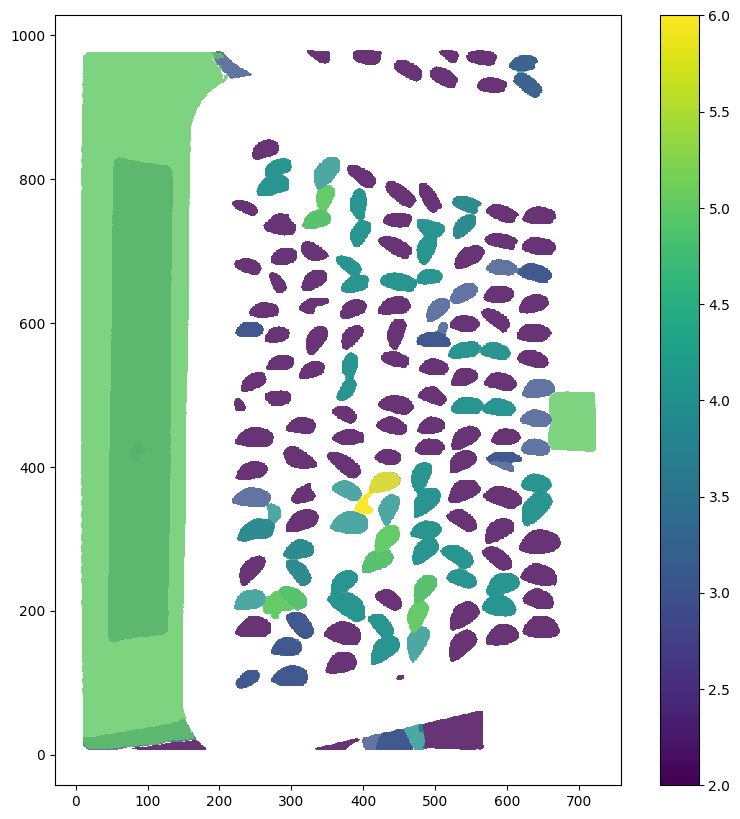

In [9]:
df[df.n_intersects.between(1, 10)].plot(column="n_intersects", alpha=.8, legend=True, figsize=(10,10))

In [10]:
problem = df[df.n_intersects == 6].iloc[0]
problem

segmentation       [[False, False, False, False, False, False, Fa...
area                                                           490.0
bbox                                              [387, 333, 26, 30]
predicted_iou                                               0.926228
point_coords                                  [[405.78125, 353.625]]
stability_score                                             0.965863
crop_box                                            [0, 0, 742, 984]
geometry           POLYGON ((401 333, 402 333, 402 334, 410 334, ...
n_intersects                                                       6
Name: (180, 0), dtype: object

segmentation    area   
48  0  [[False, False, False, False, False, False, Fa...  1311.0  \
56  0  [[False, False, False, False, False, False, Fa...   820.0   
84  0  [[False, False, False, False, False, False, Fa...   988.0   
180 0  [[False, False, False, False, False, False, Fa...   490.0   
188 0  [[False, False, False, False, False, False, Fa...  1432.0   

                     bbox  predicted_iou            point_coords   
48  0  [354, 307, 53, 30]       0.984597  [[382.59375, 322.875]]  \
56  0  [356, 352, 41, 28]       0.983525  [[382.59375, 353.625]]   
84  0  [408, 363, 43, 29]       0.978348  [[452.15625, 384.375]]   
180 0  [387, 333, 26, 30]       0.926228  [[405.78125, 353.625]]   
188 0  [388, 335, 63, 57]       0.892132  [[428.96875, 384.375]]   

       stability_score          crop_box   
48  0         0.988636  [0, 0, 742, 984]  \
56  0         0.990291  [0, 0, 742, 984]   
84  0         0.984970  [0, 0, 742, 984]   
180 0         0.965863  [0, 0, 742, 984]   
188 0         0.963649  [0, 0, 742, 984]   

                                                geometry  n_intersects  
48  0  POLYGON ((374.000 307.000, 397.000 307.000, 39...             4  
56  0  POLYGON ((384.000 352.000, 391.000 352.000, 39...             4  
84  0  POLYGON ((410.000 363.000, 416.000 363.000, 41...             4  
180 0  POLYGON ((401.000 333.000, 402.000 333.000, 40...             6  
188 0  POLYGON ((397.000 335.000, 410.000 335.000, 41...             6

<Axes: >

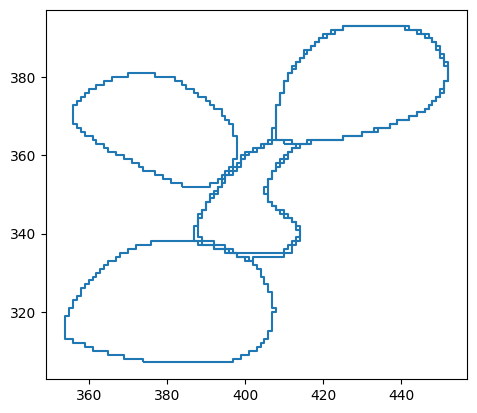

In [11]:
display(df[df.intersects(problem.geometry) & (df.n_intersects < 10)])
df[df.intersects(problem.geometry) & (df.n_intersects < 10)].boundary.plot()

In [12]:
x1, y1, x2, y2 = df[df.intersects(problem.geometry) & (df.n_intersects < 10)].total_bounds
x1, y1, x2, y2

(354.0, 307.0, 452.0, 393.0)

In [13]:
df[df.intersects(problem.geometry) & (df.n_intersects < 10)]

segmentation    area   
48  0  [[False, False, False, False, False, False, Fa...  1311.0  \
56  0  [[False, False, False, False, False, False, Fa...   820.0   
84  0  [[False, False, False, False, False, False, Fa...   988.0   
180 0  [[False, False, False, False, False, False, Fa...   490.0   
188 0  [[False, False, False, False, False, False, Fa...  1432.0   

                     bbox  predicted_iou            point_coords   
48  0  [354, 307, 53, 30]       0.984597  [[382.59375, 322.875]]  \
56  0  [356, 352, 41, 28]       0.983525  [[382.59375, 353.625]]   
84  0  [408, 363, 43, 29]       0.978348  [[452.15625, 384.375]]   
180 0  [387, 333, 26, 30]       0.926228  [[405.78125, 353.625]]   
188 0  [388, 335, 63, 57]       0.892132  [[428.96875, 384.375]]   

       stability_score          crop_box   
48  0         0.988636  [0, 0, 742, 984]  \
56  0         0.990291  [0, 0, 742, 984]   
84  0         0.984970  [0, 0, 742, 984]   
180 0         0.965863  [0, 0, 742, 984]   
188 0         0.963649  [0, 0, 742, 984]   

                                                geometry  n_intersects  
48  0  POLYGON ((374.000 307.000, 397.000 307.000, 39...             4  
56  0  POLYGON ((384.000 352.000, 391.000 352.000, 39...             4  
84  0  POLYGON ((410.000 363.000, 416.000 363.000, 41...             4  
180 0  POLYGON ((401.000 333.000, 402.000 333.000, 40...             6  
188 0  POLYGON ((397.000 335.000, 410.000 335.000, 41...             6

(307.0, 393.0)

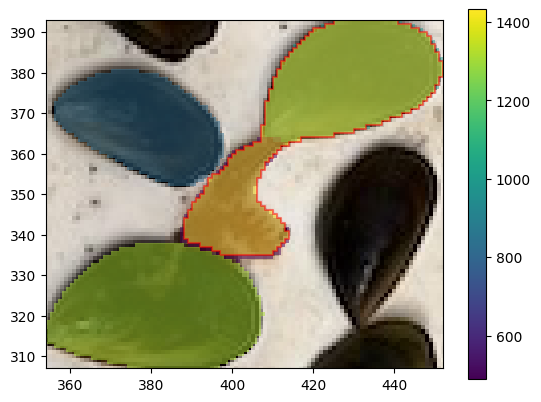

In [14]:
plt.imshow(img)
df[df.intersects(problem.geometry) & (df.n_intersects < 10)].plot(column="area", legend=True, ax=plt.gca(), alpha=.5)
df[df.intersects(problem.geometry) & (df.n_intersects < 10) & (df.area > 1400)].boundary.plot(color="red", ax=plt.gca(), alpha=.5)
plt.xlim(x1,x2)
plt.ylim(y1,y2)

<Axes: >

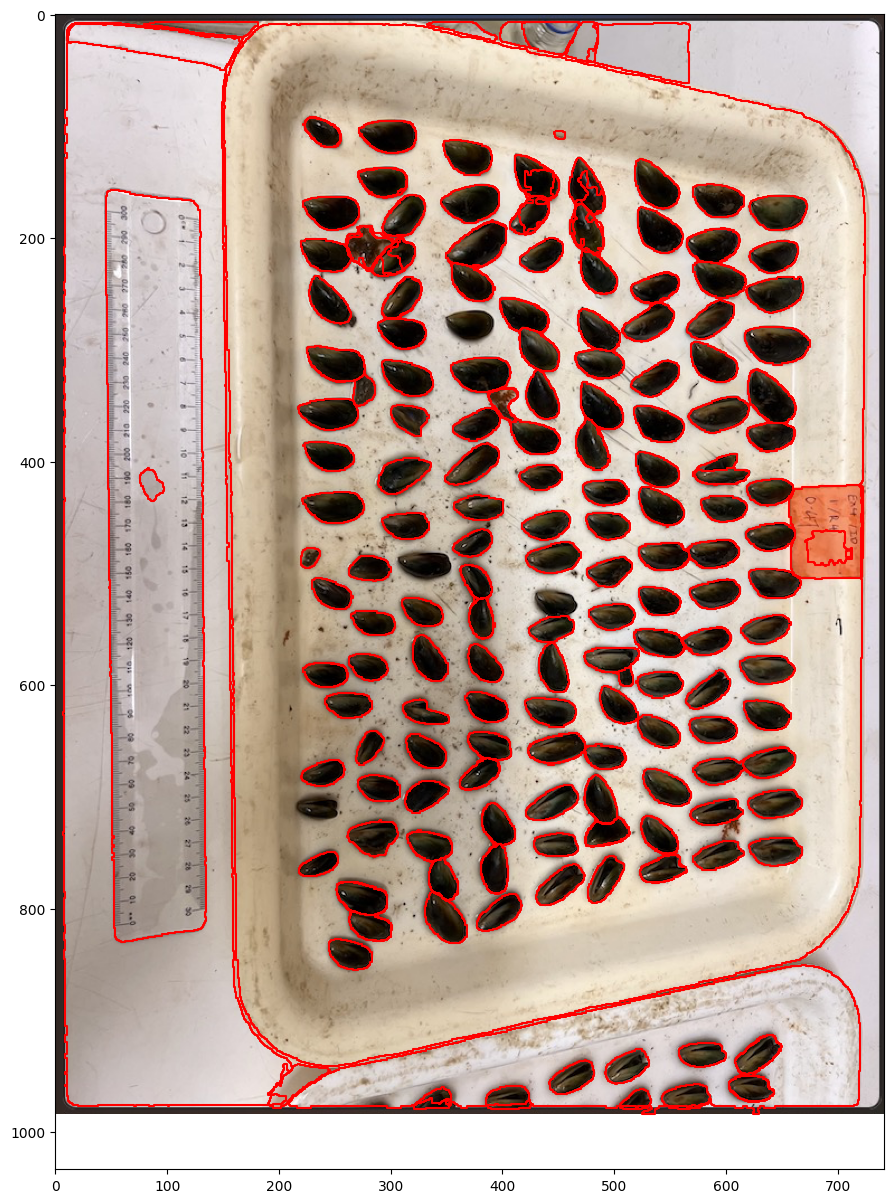

In [15]:
plt.figure(figsize=(15,15))
plt.imshow(img)
df.boundary.plot(color="red", ax=plt.gca())

In [16]:
df = df.sort_values(by="area", ascending=False)
df

segmentation      area   
189 0  [[False, False, False, False, False, False, Fa...  474123.0  \
192 0  [[False, False, False, False, False, False, Fa...  143882.0   
0   0  [[False, False, False, False, False, False, Fa...   55264.0   
190 0  [[False, False, False, False, False, False, Fa...   40237.0   
1   0  [[False, False, False, False, False, False, Fa...    5215.0   
...                                                  ...       ...   
182 0  [[False, False, False, False, False, False, Fa...     420.0   
160 0  [[False, False, False, False, False, False, Fa...     384.0   
175 0  [[False, False, False, False, False, False, Fa...     343.0   
187 0  [[False, False, False, False, False, False, Fa...     235.0   
193 0  [[False, False, False, False, False, False, Fa...      58.0   

                       bbox  predicted_iou            point_coords   
189 0    [151, 8, 573, 932]       0.997716  [[220.28125, 814.875]]  \
192 0      [7, 8, 204, 968]       0.944285   [[81.15625, 384.375]]   
0   0    [45, 157, 89, 672]       1.012357   [[81.15625, 169.125]]   
190 0  [209, 850, 510, 133]       0.996687  [[591.28125, 876.375]]   
1   0    [657, 421, 65, 83]       1.006585  [[660.84375, 476.625]]   
...                     ...            ...                     ...   
182 0    [321, 960, 32, 18]       0.920126  [[336.21875, 968.625]]   
160 0     [76, 406, 20, 28]       0.949560   [[81.15625, 415.125]]   
175 0    [505, 961, 27, 17]       0.938568  [[521.71875, 968.625]]   
187 0    [220, 477, 16, 17]       0.898391  [[220.28125, 476.625]]   
193 0      [446, 104, 9, 6]       0.884306  [[452.15625, 107.625]]   

       stability_score          crop_box   
189 0         0.956580  [0, 0, 742, 984]  \
192 0         0.966534  [0, 0, 742, 984]   
0   0         0.987980  [0, 0, 742, 984]   
190 0         0.957932  [0, 0, 742, 984]   
1   0         0.988195  [0, 0, 742, 984]   
...                ...               ...   
182 0         0.969484  [0, 0, 742, 984]   
160 0         0.976923  [0, 0, 742, 984]   
175 0         0.968661  [0, 0, 742, 984]   
187 0         0.974684  [0, 0, 742, 984]   
193 0         0.950000  [0, 0, 742, 984]   

                                                geometry  n_intersects  
189 0  POLYGON ((190.000 8.000, 207.000 8.000, 207.00...           176  
192 0  POLYGON ((17.000 8.000, 43.000 8.000, 43.000 9...             5  
0   0  POLYGON ((49.000 157.000, 57.000 157.000, 57.0...             3  
190 0  POLYGON ((667.000 850.000, 672.000 850.000, 67...            12  
1   0  POLYGON ((708.000 421.000, 721.000 421.000, 72...             5  
...                                                  ...           ...  
182 0  POLYGON ((345.000 960.000, 348.000 960.000, 34...             2  
160 0  POLYGON ((82.000 406.000, 84.000 406.000, 84.0...             3  
175 0  POLYGON ((522.000 961.000, 527.000 961.000, 52...             2  
187 0  POLYGON ((224.000 477.000, 232.000 477.000, 23...             2  
193 0  POLYGON ((447.000 104.000, 454.000 104.000, 45...             2  

[197 rows x 9 columns]

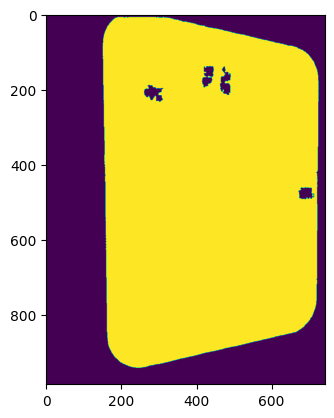

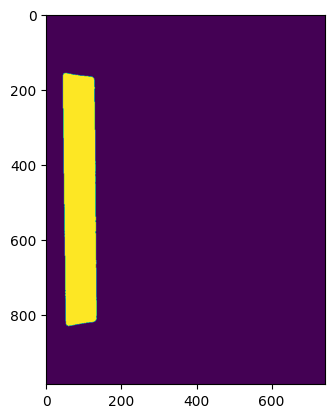

In [17]:
# Tray is largest, then the desk, then the ruler
tray = df.iloc[0]
plt.imshow(tray["segmentation"])
plt.show()
ruler = df.iloc[2]
plt.imshow(ruler["segmentation"])

In [18]:
ruler

segmentation       [[False, False, False, False, False, False, Fa...
area                                                         55264.0
bbox                                              [45, 157, 89, 672]
predicted_iou                                               1.012357
point_coords                                   [[81.15625, 169.125]]
stability_score                                              0.98798
crop_box                                            [0, 0, 742, 984]
geometry           POLYGON ((49 157, 57 157, 57 158, 62 158, 62 1...
n_intersects                                                       3
Name: (0, 0), dtype: object

In [19]:
ruler_height = ruler["bbox"][3]
# pixels to cm conversion. ruler is 32cm long
px_per_cm = ruler_height / 32
px_per_cm

21.0

<Axes: >

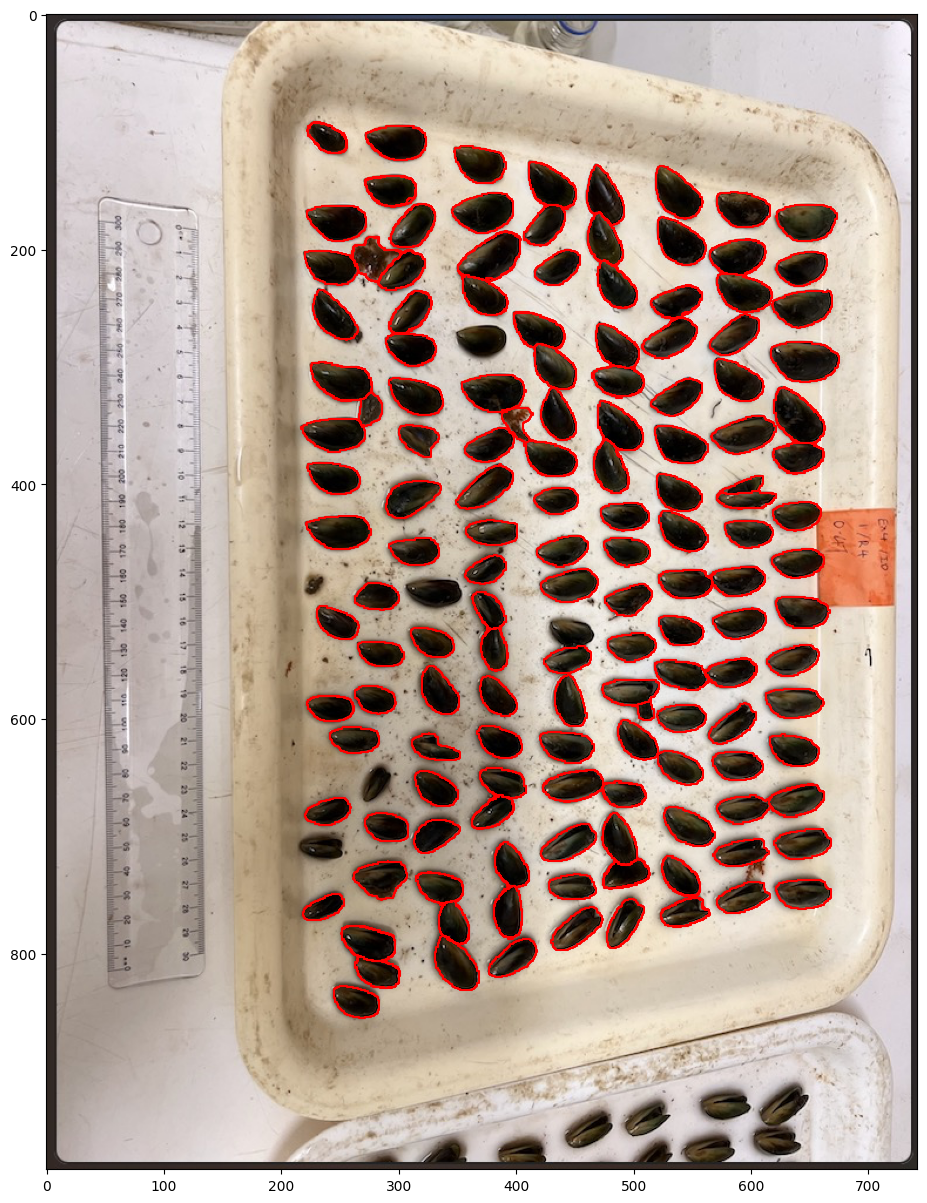

In [20]:
# Filter to just shapes in the tray
df = df[df.within(box(*tray.geometry.bounds).buffer(-5)) & (df.area > 500)]
plt.figure(figsize=(15,15))
plt.imshow(img)
df.boundary.plot(ax=plt.gca(), color="red")

In [21]:
df

segmentation    area   
118 0  [[False, False, False, False, False, False, Fa...  2313.0  \
183 0  [[False, False, False, False, False, False, Fa...  2200.0   
41  0  [[False, False, False, False, False, False, Fa...  2190.0   
191 0  [[False, False, False, False, False, False, Fa...  1997.0   
171 0  [[False, False, False, False, False, False, Fa...  1907.0   
...                                                  ...     ...   
131 0  [[False, False, False, False, False, False, Fa...   586.0   
166 0  [[False, False, False, False, False, False, Fa...   585.0   
142 0  [[False, False, False, False, False, False, Fa...   578.0   
161 0  [[False, False, False, False, False, False, Fa...   564.0   
109 0  [[False, False, False, False, False, False, Fa...   512.0   

                     bbox  predicted_iou            point_coords   
118 0  [350, 185, 52, 70]       0.969360  [[359.40625, 230.625]]  \
183 0  [565, 192, 52, 60]       0.917540  [[591.28125, 230.625]]   
41  0  [619, 318, 43, 71]       0.985705  [[637.65625, 353.625]]   
191 0  [466, 329, 41, 77]       0.957908  [[498.53125, 353.625]]   
171 0  [398, 253, 52, 65]       0.941882  [[428.96875, 292.125]]   
...                   ...            ...                     ...   
131 0  [356, 460, 34, 24]       0.965892  [[359.40625, 476.625]]   
166 0   [223, 92, 99, 31]       0.944357  [[289.84375, 107.625]]   
142 0  [311, 612, 40, 22]       0.961633  [[336.21875, 630.375]]   
161 0  [571, 406, 49, 14]       0.948707  [[591.28125, 415.125]]   
109 0  [218, 749, 34, 21]       0.972152  [[243.46875, 753.375]]   

       stability_score          crop_box   
118 0         0.973909  [0, 0, 742, 984]  \
183 0         0.977987  [0, 0, 742, 984]   
41  0         0.978300  [0, 0, 742, 984]   
191 0         0.974790  [0, 0, 742, 984]   
171 0         0.977143  [0, 0, 742, 984]   
...                ...               ...   
131 0         0.983108  [0, 0, 742, 984]   
166 0         0.975734  [0, 0, 742, 984]   
142 0         0.972927  [0, 0, 742, 984]   
161 0         0.963415  [0, 0, 742, 984]   
109 0         0.990272  [0, 0, 742, 984]   

                                                geometry  n_intersects  
118 0  POLYGON ((388.000 185.000, 394.000 185.000, 39...             4  
183 0  POLYGON ((588.000 192.000, 602.000 192.000, 60...             4  
41  0  POLYGON ((625.000 318.000, 630.000 318.000, 63...             4  
191 0  POLYGON ((471.000 329.000, 476.000 329.000, 47...             4  
171 0  POLYGON ((402.000 253.000, 403.000 253.000, 40...             5  
...                                                  ...           ...  
131 0  POLYGON ((380.000 460.000, 384.000 460.000, 38...             2  
166 0  POLYGON ((227.000 93.000, 225.000 93.000, 225....             3  
142 0  POLYGON ((325.000 612.000, 326.000 612.000, 32...             2  
161 0  POLYGON ((575.000 406.000, 576.000 406.000, 57...             3  
109 0  POLYGON ((242.000 749.000, 250.000 749.000, 25...             2  

[169 rows x 9 columns]

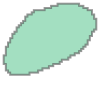

In [22]:
sample = df.sample(1)
poly = sample.geometry.iloc[0]
poly

In [23]:
# Get diameter of polygon by brute force, checking each point pair
def get_diameter(poly):
    max_dist = 0
    coords = [Point(x,y) for x,y in poly.exterior.coords]
    result_coords = []
    for a in coords:
        for b in coords:
            dist = a.distance(b)
            if dist > max_dist:
                max_dist = dist
                result_coords = [a, b]

    line = LineString(result_coords)
    return line

line = get_diameter(poly)
line, line.length

(<LINESTRING (567 705, 527 677)>, 48.82622246293481)

Text(547.0, 691.0, '48.83px')

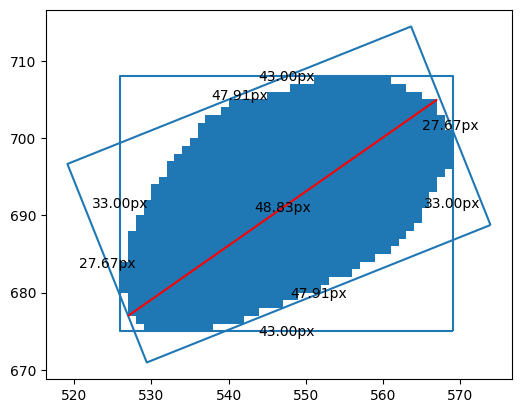

In [24]:
def get_dist(a, b):
    return Point(a).distance(Point(b))

def midpoint(a, b):
    return ((a[0]+b[0])/2, (a[1]+b[1])/2)

def annotate_dist(poly):
    coords = list(poly.exterior.coords)
    for i in range(len(coords)-1):
        a, b = coords[i], coords[i+1]
        dist = get_dist(a, b)
        plt.annotate(f"{dist:.2f}px", xy=midpoint(a, b), ha='center', va='center')

mrr = poly.minimum_rotated_rectangle
bbox = box(*poly.bounds)
line = get_diameter(poly)

ax = gpd.GeoSeries([poly, mrr.exterior, bbox.exterior]).plot()
gpd.GeoSeries(line).plot(color="red", ax=ax)
annotate_dist(bbox)
annotate_dist(mrr)
plt.annotate(f"{line.length:.2f}px", xy=midpoint(*list(line.coords)), ha='center', va='center')

In [25]:
df["diameter_line"] = df.geometry.progress_apply(get_diameter)
df["diameter_line"]

  0%|          | 0/169 [00:00<?, ?it/s]

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


118  0    LINESTRING (397.000 186.000, 370.000 255.000)
183  0    LINESTRING (615.000 247.000, 566.000 200.000)
41   0    LINESTRING (625.000 318.000, 649.000 389.000)
191  0    LINESTRING (471.000 329.000, 489.000 407.000)
171  0    LINESTRING (447.000 318.000, 399.000 254.000)
                              ...                      
131  0    LINESTRING (391.000 466.000, 356.000 479.000)
166  0     LINESTRING (224.000 94.000, 253.000 117.000)
142  0    LINESTRING (352.000 633.000, 311.000 618.000)
161  0    LINESTRING (621.000 408.000, 571.000 413.000)
109  0    LINESTRING (253.000 753.000, 218.000 768.000)
Name: diameter_line, Length: 169, dtype: geometry

In [26]:
ruler.diameter_line = get_diameter(ruler.geometry)

  0%|          | 0/169 [00:00<?, ?it/s]

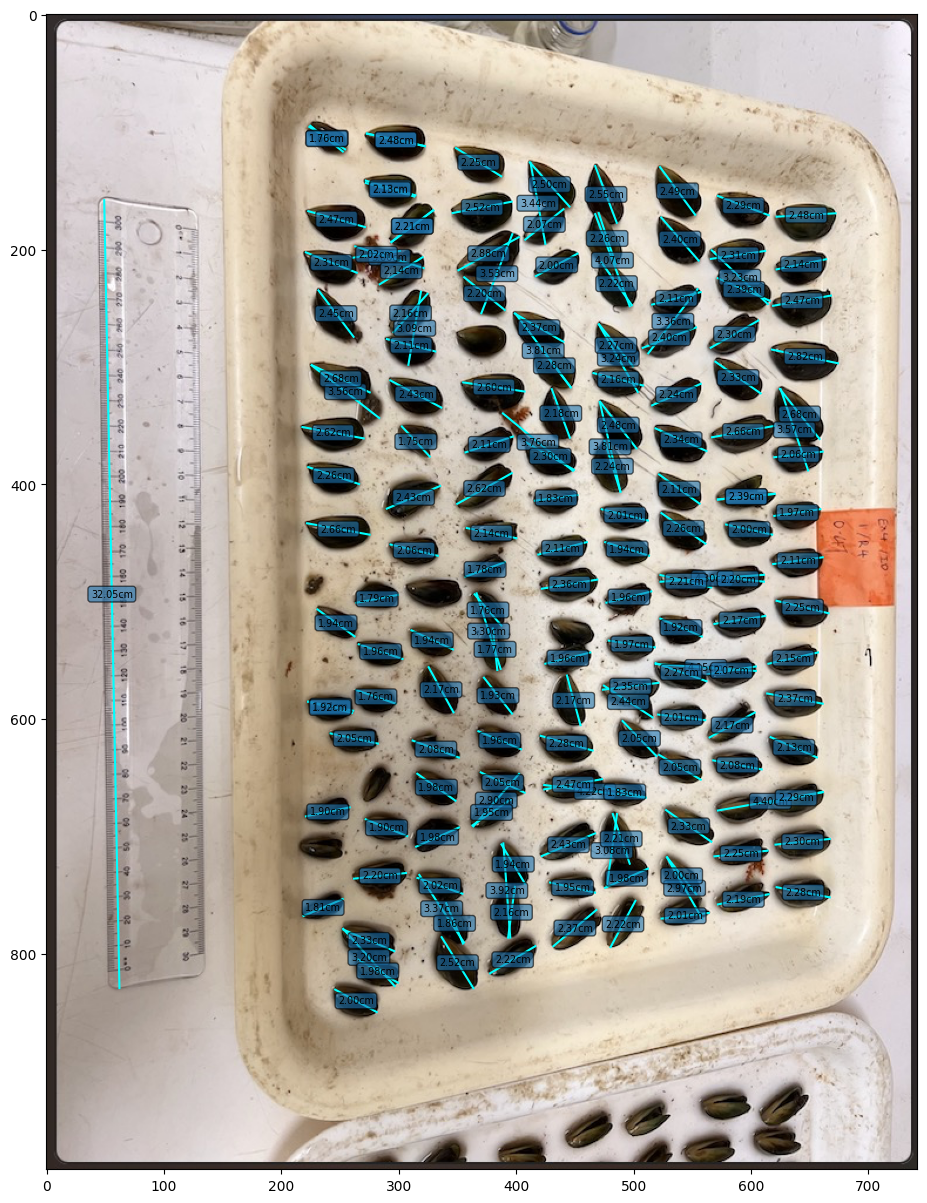

In [27]:
def annotate_length(line):
    gpd.GeoSeries(line).plot(color="cyan", ax=plt.gca())
    x, y = midpoint(*list(line.coords))
    plt.text(s=f"{line.length/px_per_cm:.2f}cm", x=x, y=y, ha='center', va='center', bbox=dict(boxstyle="round", alpha=.6), fontsize="x-small")

plt.figure(figsize=(15,15))
plt.imshow(img)
annotate_length(ruler.diameter_line)
for line in tqdm(df.diameter_line): # & (df.n_intersects == 2)]):
    annotate_length(line)

In [28]:
df["length_cm"] = df.diameter_line.length / px_per_cm
df.length_cm.describe()

/mnt/nid_env/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


count    169.000000
mean       2.382274
std        0.551070
min        1.752226
25%        2.020305
50%        2.221315
75%        2.472525
max        4.399804
Name: length_cm, dtype: float64